# Numerické řešení konvekce s difusí pomocí MKO

## Síť pro MKO

In [1]:
using PyPlot
using StaticArrays
import Base.-, Base.+, Base.*, Base./
using ForwardDiff

const Vec2d = SVector{2,Float64};
const VecList = Array{Vec2d,1};

In [2]:
immutable Cell
    id  :: Int
    x   :: Vec2d
    vol :: Float64
end

const CellList = Array{Cell,1};

In [3]:
immutable Face
    id    :: Int
    x     :: Vec2d
    s     :: Vec2d
    owner :: Int
    neigh :: Int
end;

const FaceList = Array{Face,1};

In [4]:
const PatchDict = Dict{String,FaceList};

In [5]:
type Mesh
    points  :: VecList
    faces   :: FaceList
    cells   :: CellList
    patches :: PatchDict
end

In [6]:
function cartesian_mesh(nx, ny)
    Δx, Δy = 1.0/nx, 1.0/ny
    
    pid(i,j) = i + j*(nx+1) + 1
    cid(i,j) = i + (j-1)*nx

    fid_  = 0 
    function fid() 
        fid_+=1
        return fid_
    end
    
    # mesh points
    points = VecList()
    for j=0:ny,i=0:nx
        push!(points, Vec2d(i*Δx, j*Δy))
    end
    
    faces = FaceList()
    for j=1:ny, i=1:nx
        if i<nx
            x = Vec2d(i*Δx,(j-0.5)*Δy)
            s = Vec2d(Δy,0)
            push!(faces, Face(fid(), x, s, cid(i,j), cid(i+1,j)))
        end
        
        if j<ny
            x = Vec2d((i-0.5)*Δx,j*Δy)
            s = Vec2d(0,Δx)
            push!(faces, Face(fid(), x, s, cid(i,j), cid(i,j+1)))
        end
            
    end
    
    # mesh cells
    cells = CellList()
    for j=1:ny,i=1:nx
        push!(cells, Cell(cid(i,j), Vec2d((i-0.5)*Δx,(j-0.5)*Δy), Δx*Δy))
    end
    
    # boundary patches
    patches = PatchDict(
        "bottom" => [ Face( fid(), Vec2d((i-0.5)*Δx,0), Vec2d(0,-Δy), cid(i,1), 0) for i=1:nx],
        "top"    => [ Face( fid(), Vec2d((i-0.5)*Δx,1), Vec2d(0,Δy), cid(i,ny), 0) for i=1:nx],
        "left"   => [ Face( fid(), Vec2d(0,(j-0.5)*Δy), Vec2d(-Δx,0), cid(1,j), 0) for j=1:ny],
        "right"  => [ Face( fid(), Vec2d(1,(j-0.5)*Δy), Vec2d(Δx,0),  cid(nx,j), 0) for j=1:ny],
    )
    
    return Mesh(points, faces, cells, patches)
end

cartesian_mesh (generic function with 1 method)

In [7]:
m2 = cartesian_mesh(2,2);

In [8]:
for p in m2.points
    println(p)
end

[0.0, 0.0]
[0.5, 0.0]
[1.0, 0.0]
[0.0, 0.5]
[0.5, 0.5]
[1.0, 0.5]
[0.0, 1.0]
[0.5, 1.0]
[1.0, 1.0]


In [9]:
for f in m2.faces
    println(f)
end

Face(1, [0.5, 0.25], [0.5, 0.0], 1, 2)
Face(2, [0.25, 0.5], [0.0, 0.5], 1, 3)
Face(3, [0.75, 0.5], [0.0, 0.5], 2, 4)
Face(4, [0.5, 0.75], [0.5, 0.0], 3, 4)


In [10]:
for c in m2.cells
    println(c)
end

Cell(1, [0.25, 0.25], 0.25)
Cell(2, [0.75, 0.25], 0.25)
Cell(3, [0.25, 0.75], 0.25)
Cell(4, [0.75, 0.75], 0.25)


In [11]:
for (name,faces) in m2.patches
    println("PATCH ", name)
    for f in faces
        println(f)
    end
    println()
end

PATCH left
Face(9, [0.0, 0.25], [-0.5, 0.0], 1, 0)
Face(10, [0.0, 0.75], [-0.5, 0.0], 3, 0)

PATCH bottom
Face(5, [0.25, 0.0], [0.0, -0.5], 1, 0)
Face(6, [0.75, 0.0], [0.0, -0.5], 2, 0)

PATCH right
Face(11, [1.0, 0.25], [0.5, 0.0], 2, 0)
Face(12, [1.0, 0.75], [0.5, 0.0], 4, 0)

PATCH top
Face(7, [0.25, 1.0], [0.0, 0.5], 3, 0)
Face(8, [0.75, 1.0], [0.0, 0.5], 4, 0)



## Uložení dat a okrajových podmínek

K uložení dat použijeme speciální datovou strukturu `Field`, která zahrnuje jak hodnoty řešení ve středech buněk, tak odkaz (ukazatel) na síť a seznam okrajových podmínek.

In [12]:
type Field
    values
    mesh
    boundaries
end

Field(m::Mesh) = Field( zeros(length(m.cells)), m, Dict{String,Any}());
Field(values, m::Mesh) = Field(values, m, Dict{String,Any}());

### Operace se strukturou `Field`

Se strukturou `Field` budeme provádět aritmetické operace (sčítat, odčítat, násobit, dělit, ...) prvek po prvku

In [13]:
for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Field)
            assert(a.mesh == b.mesh)
            Field(broadcast($op,a.values,b.values), a.mesh)
        end
    end
end

In [14]:
a2 = Field(m2); a2.values = ones(4);
b2 = Field(m2); b2.values = 3*ones(4);

In [15]:
c2 = a2 * b2;
c2.values

4-element Array{Float64,1}:
 3.0
 3.0
 3.0
 3.0

Umíme k ní přičíst konstantu ke každému prvku, umíme přičíst pole správné velikosti a umíme jí vynásobit či vydělit konstantou. Dále umíme unární mínus.

In [16]:
for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Number)
            Field(broadcast($op,a.values,b), a.mesh)
        end
    end
end      

for op ∈ [:+, :-, :*, :/]
    @eval begin
        function ($op)(a::Field, b::Array{Float64,1})
            assert( size(a.values) == size(b) )
            Field(broadcast($op,a.values,b), a.mesh)
        end
    end
end      

-(a::Field) = Field(-a.values, a.mesh);

In [17]:
c2 = a2 / 3;
c2.values

4-element Array{Float64,1}:
 0.333333
 0.333333
 0.333333
 0.333333

### Přiřazení do `Field` 

Zde je třeba trochu opatrnosti. Při prostém přiřazení dojde v jazyce Julia pouze k nastavení ukazatele na hodnotu na pravé straně. To ale mimo jiné vymaže odkaz na okrajové podmínky. Proto raději definujeme oprátor <- který pouze kopíruje položku values.

In [18]:
function ←(a::Field, b::Field)
    assert(a.mesh == b.mesh)
    a.values = copy(b.values)
end

← (generic function with 1 method)

In [19]:
b2.values = 3*ones(4)
c2 ← b2;
d2 = b2;
b2.values[1] = 5;
println(c2.values)
println(d2.values)

[3.0, 3.0, 3.0, 3.0]
[5.0, 3.0, 3.0, 3.0]


### Okrajová podmínka

Pro metodu konečných objemů potřebujeme umět vyčíslit hodnotu řešení a případně gradientu řešení na hranici. Jednou z možností je implementovat podminku tak, že 
$$
    u_b = c_1 + c_2 u_1,
$$
kde $u_b$ je hodnota na hranici, $u_1$ je hodnota ve středu první buňky a $c_1$ a $c_2$ jsou koeficienty.

In [20]:
function boundary_value(patch, i::Int)
    c = boundary_coeffs(patch,i)
    u1 = patch.field.values[patch.faces[i].owner]
    return c[1] + c[2]*u1
end;

Dirichletova podmínka je potom implementována tak, že $c_1$ je předepsaná hodnota a $c_2=0$.

In [21]:
type DirichletPatch
    value :: Array{Float64,1}
    field :: Field
    faces :: FaceList
end

boundary_coeffs(p::DirichletPatch, i::Int) = (p.value[i], 0.0)

# Pomocna funkce pro nastaveni Dirichletovy okrajove podminky s jednou zadanou hodnotou
function set_dirichlet_patch!(u::Field, name::String, val::Float64)
    value = [val for i=1:length(u.mesh.patches[name])]
    u.boundaries[name] = DirichletPatch(value, u, u.mesh.patches[name])
end;

Neumannova podmínka je implementována jako $c_1=0$ a $c_2=1$. Pro případ zadané nenulové normálvé derivace je výpočet následující:
$$
\frac{u_b-u_1}{\delta} = \frac{\partial u}{\partial n},
$$
kde
$$
    \delta = (\vec{x}_f - \vec{x}_o)\cdot \vec{n}.
$$
$\vec{x}_f$ je střed stěny, $\vec{x}_o$ je střed buňky. Tzn.
$$
    u_b = \delta \frac{\partial u}{\partial n} + u_1.
$$

In [22]:
type NeumannPatch
    deriv :: Array{Float64,1}
    field :: Field
    faces :: FaceList
end


function boundary_coeffs(p::NeumannPatch, i::Int)
    u = p.field
    m = u.mesh
    f = p.faces[i]
    δ = dot(f.x - m.cells[f.owner].x, f.s) / norm(f.s)
    return (p.deriv[i] * δ, 1.0)
end

function set_neumann_patch!(u::Field, name::String, der::Float64)
    u.boundaries[name] = NeumannPatch([der for i=1:length(u.mesh.patches[name])], u, u.mesh.patches[name])
end;


In [23]:
m3 = cartesian_mesh(3,3);

In [24]:
u3 = Field(m3);
set_dirichlet_patch!(u3, "left", 1.0);
set_dirichlet_patch!(u3, "bottom", 0.0);
set_neumann_patch!(u3, "right", 0.0);
set_neumann_patch!(u3, "top", 0.0);

## Výpočet pomocí MKO

Řešíme rovnici

\begin{equation}
    \frac{\partial u}{\partial t} + \nabla\cdot(\vec{v} u) = 0
\end{equation}
s $\vec{v}=[1,0.5]$, počáteční podmínkou $u(0,\vec{x}) = 0$ a s okrajovými podmínkami $u=0$ pro $x=0$ a $u=1$ pro $y=0$.

Výpočet provedeme pomocí MKO v explicitním tvaru, toky přes hranice budeme aproximovat pomocí metody *upwind*. Tedy
$$
    u_i^{n+1} = u_i^n - \frac{\Delta t}{|\Omega_i|} \sum_{j} H_f(u_i^n, u_j^n, \vec{S}_{ij}), 
$$
kde $j$ probíhá přes sousedy buňky $i$. 

Sumy na pravé straně vyčíslíme dle následujícího algoritmu:
1. Vynulujeme $r_i:=0$
2. Pro všechny vnitřní stěny vypočteme tok z buňky *owner* do *neighbour*, ten pak přidáme k $r[owner]$ a odebereme od $r[neighbour]$ (pozn. pozor na znaménko!).
3. Podobně projdeme všechny hraniční stěny, zde není buňka *neighbour* a výpočet toku musíme provést dle zadané okrajové podmíny.
4. Nakonec celé pole dělíme objemy buněk.

In [25]:
v = Vec2d(1, 0.5);

# Tok typu upwind
H(ul, ur, s) = dot(v,s)>0 ? dot(v,s)*ul : dot(v,s)*ur

H (generic function with 1 method)

In [26]:
function R(u::Field)
    m = u.mesh
    r = zeros(u.values)    
    
    for f ∈ m.faces
        flux = H( u.values[f.owner], u.values[f.neigh], f.s)
        r[f.owner] += flux
        r[f.neigh] -= flux
    end
    
    for (name,faces) ∈ m.patches
        bc = u.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            ub = boundary_value(bc, i)
            flux = H( u.values[f.owner], ub, f.s)
            r[f.owner] += flux
        end
    end
    
    for c in m.cells
        r[c.id] /= c.vol
    end
    
    return r
end

R (generic function with 1 method)

In [27]:
R(u3)

9-element Array{Float64,1}:
 -3.0
  0.0
  0.0
 -3.0
  0.0
  0.0
 -3.0
  0.0
  0.0

In [28]:
m = cartesian_mesh(50,50);

u = Field(m)
set_dirichlet_patch!(u, "left", 1.0);
set_dirichlet_patch!(u, "bottom", 0.0);
set_neumann_patch!(u, "right", 0.0);
set_neumann_patch!(u, "top", 0.0);

In [29]:
Δt = 0.01
for t = 0 : Δt : 2
    u ← u - Δt * R(u)
end

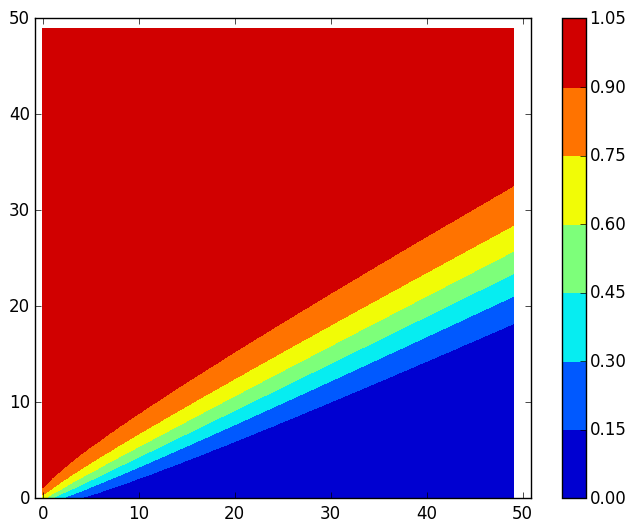

In [30]:
contourf(reshape(u.values,50,50)'); 
colorbar(); axis("equal");

## Implicitní metoda

Implicitní metoda je výpočetně náročnější (v každém kroku řešíme soustavu rovnic), nicméně často bývá efektivnější neboť umožňuje použití delšího časového kroku. Pokusíme se naprogramovat implicitní metodu pro řešení **lineární** parciální diferenciální rovnice tak, že budeme jednotlivé operátory (derivace) reprezentovat jako trojici matice, neznámá a absolutní člen, tj.
$$
    L(x) = A x + b.
$$

In [31]:
type Equation
    A
    x
    b
end

S rovnicemi umíme provádět běžné operace 

In [32]:
# Scitani a odcitani rovnic 
for op ∈ [:+, :-]
    @eval begin
        function ($op)(e1::Equation, e2::Equation)
            assert(e1.x == e2.x)
            Equation(($op)(e1.A, e2.A), e1.x, $(op)(e1.b, e2.b))
        end
    end
end

# Pricteni/odecteni pole o spravne velikosti 
for op ∈ [:+, :-]
    @eval begin
        function ($op)(e1::Equation, f::Array{Float64,1})
            assert(size(e1.x) == size(f))
            Equation(copy(e1.A), e1.x, $(op)(e1.b, f))
        end
    end
end

# Vynasobeni rovnice konstantou
*(a::Float64, eq::Equation) = Equation(a*eq.A, eq.x, a*eq.b);

Rovnice umíme vyřešit

In [33]:
function solve!(eqn::Equation)
    x = eqn.A \ eqn.b
    for i in eachindex(eqn.x)
        eqn.x[i] = -x[i]
    end
end;

### Operátor $\partial/\partial t$

Časovou derivaci aproximujeme jako
$$
    \frac{\partial u}{\partial t} \approx \frac{u^{n+1}-u^{n}}{\Delta t}
$$
tj. jako 
$$
A u^{n+1} + b
$$
kde $A=diag({1/\Delta t})$ a $b_i=- u_i^n/\Delta t$.

In [34]:
function ddt(f::Field,Δt)
    n = length(f.values)
    Equation(speye(n)/Δt, f.values, -f.values/Δt)
end;    

In [35]:
ddt(u3,0.1)

Equation(
  [1, 1]  =  10.0
  [2, 2]  =  10.0
  [3, 3]  =  10.0
  [4, 4]  =  10.0
  [5, 5]  =  10.0
  [6, 6]  =  10.0
  [7, 7]  =  10.0
  [8, 8]  =  10.0
  [9, 9]  =  10.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

Zkusíme vyřešit soustavu ODE $\dot{u} = 1$ s počáteční podmínkou $u(0)-0$. Uděláme 10 kroků s $\Delta t=0.1$.

In [36]:
u3.values = zeros(9)
for t=1:10
    solve!(ddt(u3,0.1)-ones(9))
    print(u3.values[1], "\t")
end

0.1	0.2	0.3	0.39999999999999997	0.5	0.6	0.7	0.7999999999999999	0.9	1.0	

## Operátor $\nabla\cdot(\vec{v}u)$

Operátor je reprezentován řídkou maticí a absolutním členem $b$. Matici sestavíme stejným způsobem jako při výpočtu $r_i$ explicitní metodou.

In [37]:
function ∇(v::Vec2d, u::Field)
    A = spzeros(length(u.values),length(u.values))
    b = zeros(length(u.values))
    
    msh = u.mesh
    
    for f ∈ msh.faces
        o = f.owner
        n = f.neigh
        uo = u.values[o]
        un = u.values[n]
    
        ϕ = dot(v,f.s)
        α = max(ϕ, 0.0)
        β = min(ϕ, 0.0)
        
        A[o,o] += α / msh.cells[o].vol
        A[o,n] += β / msh.cells[o].vol
            
        A[n,o] -= α / msh.cells[n].vol
        A[n,n] -= β / msh.cells[n].vol
    end

    for (name,faces) ∈ msh.patches
        bc = u.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            coeff = boundary_coeffs(bc, i)  # tj. ub = coef[1] + coef[2]*uin
            ϕ = dot(v,f.s)
            α = max(ϕ, 0.0)
            β = min(ϕ, 0.0)

            c = boundary_coeffs(bc, i)  # tj. ub = c[1] + c[2]*uin
            A[o,o] += (α + β*c[2]) / msh.cells[o].vol
            b[o]   += β*c[1] / msh.cells[o].vol
        end
    end

    
    return Equation(A, u.values, b)
end     

∇ (generic function with 1 method)

In [38]:
full(∇(v,u3).A)

9×9 Array{Float64,2}:
  4.5   0.0   0.0   0.0   0.0   0.0   0.0   0.0  0.0
 -3.0   4.5   0.0   0.0   0.0   0.0   0.0   0.0  0.0
  0.0  -3.0   4.5   0.0   0.0   0.0   0.0   0.0  0.0
 -1.5   0.0   0.0   4.5   0.0   0.0   0.0   0.0  0.0
  0.0  -1.5   0.0  -3.0   4.5   0.0   0.0   0.0  0.0
  0.0   0.0  -1.5   0.0  -3.0   4.5   0.0   0.0  0.0
  0.0   0.0   0.0  -1.5   0.0   0.0   4.5   0.0  0.0
  0.0   0.0   0.0   0.0  -1.5   0.0  -3.0   4.5  0.0
  0.0   0.0   0.0   0.0   0.0  -1.5   0.0  -3.0  4.5

### Vlastnosti matice $A$ pro operátor $\nabla\cdot(\vec{v}u)$

Nechť A je matice získaná reprezentující lineární operátor $\nabla\cdot(\vec{v}u)$ získaná pomocí MKO a schématu **upwind**. Potom:
1. A je (neostře) diagonálně dominantní,
2. $A_{ii}>0$ a $A_{ij} \le 0$ pro $i\ne j$.
3. V řádcích odpovídajících vnitřním buňkám sítě (tj. ty, které nesousedí s žádnou hranicí) je $\sum_j A_{ij}=0$.

Vyřešíme rovnici konvekce do času $t=0.5s$ pomocí implicitní metody s krokem $\Delta t=0.05$

In [39]:
u.values = zeros(u.values)

Δt = 0.05
for t=0:Δt:0.5
    solve!( ddt(u,Δt) + ∇(v,u) ); 
end

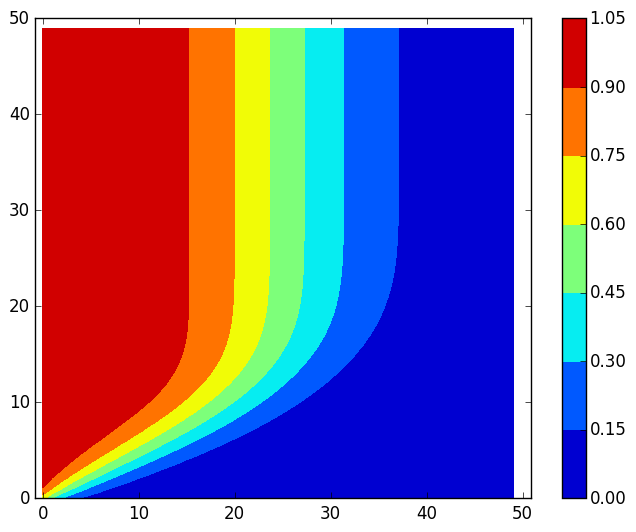

In [40]:
contourf(reshape(u.values,50,50)'); 
colorbar(); axis("equal");

### Operátor $\Delta u$

In [41]:
function Δ(μ::Float64, u::Field)
    mesh = u.mesh
    
    A = spzeros(length(u.values),length(u.values))
    b = zeros(length(u.values))

    
    for f in mesh.faces
        o, n = f.owner, f.neigh
        co, cn = mesh.cells[o], mesh.cells[n]
        
        g = μ * norm(f.s) / norm(cn.x-co.x)

        A[o,o] -= g / co.vol
        A[o,n] += g / co.vol
            
        A[n,o] += g / cn.vol
        A[n,n] -= g / cn.vol
    end
    
    for (name,faces) ∈ mesh.patches
        bc = u.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            co = mesh.cells[o]
    
            # normal derivative at boundary dudn = (ub - uin) / delta
            # with ub = c[1] + c[2]*uin, i.e.
            # dudn = c[1]/delta + (c[2]-1)/delta*uin
            
            c = boundary_coeffs(bc, i)  # tj. ub = c[1] + c[2]*uin            
            δ = dot(f.x - co.x, f.s) / norm(f.s)

            A[o,o] += μ * (c[2]-1)/δ * norm(f.s) / co.vol
            b[o] -= μ * c[1]/δ * norm(f.s) / co.vol
        end
    end
    
    Equation(A, u.values, b)
end


Δ (generic function with 1 method)

In [42]:
u.values = zeros(u.values)

Δt = 0.1
for t=0:Δt:0.5
    solve!( ddt(u,Δt) + ∇(v,u) - Δ(1.e-1,u) ); 
end

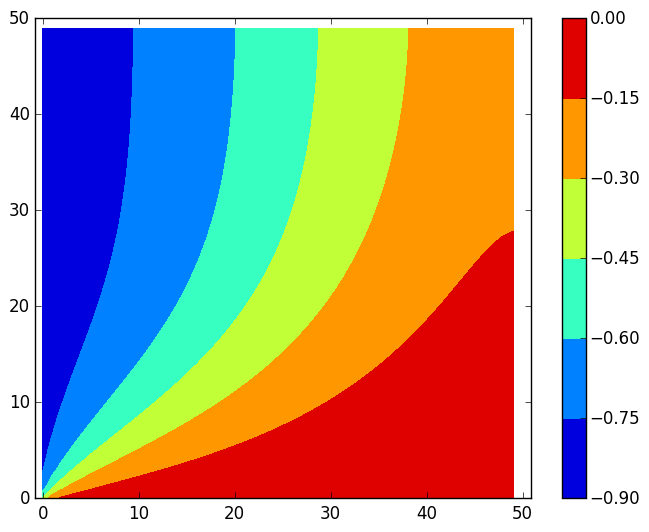

In [43]:
contourf(reshape(u.values,50,50)'); 
colorbar(); axis("equal");